## Part I

This is a dataset of over 15,000 images from MIT built to tackle the problem of indoor scene recognition. All images are in JPEG format and have been divided into 67 categories. The number of images per category varies. However, there are at least 100 images for each category.

There are some issues of  image quality in the following folder


Data Source: MIT Indoor Scenes Dataset (Links to an external site.)

This notebook performs image classification with the label having sixty one classes , done so via the below script in Python.

### Import Libraries and Set Seeds
This cell imports all necessary libraries and sets random seeds for reproducibility.

In [ ]:
import keras.backend as K
K.clear_session()

# IMPORT LIBRARIES and PACKAGES
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter

import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL #Python Imaging Library

# Per https://github.com/tensorflow/models/issues/6669
# Per https://www.tensorflow.org/datasets/overview
# FIRST run "pip install tensorflow_datasets" as tensorflow_datasets is a stand-alone pkg
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

from glob import glob
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import display  # display images
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import CSVLogger
!pip install keras_cv
import keras_cv

np.random.seed(456)
tf.random.set_seed(456)
keras.utils.set_random_seed(456)

import pathlib
from pathlib import Path
%matplotlib inline

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

### Download and Unzip Dataset
This cell downloads the dataset from Kaggle and unzips it.

In [ ]:
#!/bin/bash
!curl -L -o /content/indoor-scenes-cvpr-2019.zip https://www.kaggle.com/api/v1/datasets/download/itsahmad/indoor-scenes-cvpr-2019

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2392M  100 2392M    0     0  22.2M      0  0:01:47  0:01:47 --:--:-- 23.0M


In [ ]:
import shutil
shutil.unpack_archive('/content/indoor-scenes-cvpr-2019.zip')

### Remove Specified Directories
This cell removes the directories containing images with quality issues as specified in the problem description.

In [ ]:

deldir= ['laboratorywet',
  'laundromat',
  'library',
  'livingroom',
  'lobby',
  'locker_room']
for i in deldir:
  shutil.rmtree(f'/content/indoorCVPR_09/Images/{i}')

### Verify Dataset Structure and Count
This cell verifies the directory structure and counts the total number of images after removing the specified directories.

In [ ]:
# I manually removed the files mentioned above after unzipping it.

# I set the parent folder that contains the subfolders that are the lables
# I also set the current working directory.

img_dir = '/content/indoorCVPR_09/Images'
total_files = 0
for root, dirs, files in os.walk(str(img_dir)):
    level = root.replace(str(img_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
print(f'There are {total_files -1} images in this dataset')

Images/ (0 files)
    pantry/ (384 files)
    videostore/ (110 files)
    office/ (109 files)
    bowling/ (213 files)
    toystore/ (347 files)
    computerroom/ (114 files)
    waitingroom/ (151 files)
    corridor/ (346 files)
    winecellar/ (269 files)
    poolinside/ (174 files)
    inside_subway/ (457 files)
    jewelleryshop/ (157 files)
    hairsalon/ (239 files)
    classroom/ (113 files)
    hospitalroom/ (101 files)
    warehouse/ (506 files)
    grocerystore/ (213 files)
    prisoncell/ (103 files)
    restaurant/ (513 files)
    closet/ (135 files)
    greenhouse/ (101 files)
    dining_room/ (274 files)
    concert_hall/ (103 files)
    nursery/ (144 files)
    deli/ (258 files)
    gameroom/ (127 files)
    fastfood_restaurant/ (116 files)
    trainstation/ (153 files)
    casino/ (515 files)
    buffet/ (111 files)
    stairscase/ (155 files)
    bookstore/ (380 files)
    inside_bus/ (102 files)
    museum/ (168 files)
    bedroom/ (662 files)
    kindergarden/ (127 f

### List and Sort Image Labels
This cell lists the image labels (directory names) and sorts them alphabetically.

In [ ]:
IndoorImage_dir = [ name for name in list(os.listdir(img_dir)) if os.path.isdir(os.path.join(img_dir, name)) ]
print(f' The Indoor Image labels = {IndoorImage_dir}')

# SORT the directories in alphabetical order
IndoorImage_dir.sort()
print(f'\n The SORTED Indoor Image labels = {IndoorImage_dir}')

print(f'\nThere are {len(IndoorImage_dir)} classes of Indoor Images.')

 The Indoor Image labels = ['pantry', 'videostore', 'office', 'bowling', 'toystore', 'computerroom', 'waitingroom', 'corridor', 'winecellar', 'poolinside', 'inside_subway', 'jewelleryshop', 'hairsalon', 'classroom', 'hospitalroom', 'warehouse', 'grocerystore', 'prisoncell', 'restaurant', 'closet', 'greenhouse', 'dining_room', 'concert_hall', 'nursery', 'deli', 'gameroom', 'fastfood_restaurant', 'trainstation', 'casino', 'buffet', 'stairscase', 'bookstore', 'inside_bus', 'museum', 'bedroom', 'kindergarden', 'bakery', 'bar', 'shoeshop', 'garage', 'meeting_room', 'artstudio', 'children_room', 'movietheater', 'kitchen', 'church_inside', 'tv_studio', 'gym', 'operating_room', 'cloister', 'clothingstore', 'bathroom', 'studiomusic', 'restaurant_kitchen', 'subway', 'auditorium', 'elevator', 'mall', 'dentaloffice', 'florist', 'airport_inside']

 The SORTED Indoor Image labels = ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet',

### Check for Corrupted Images
This cell iterates through image paths to identify and print any corrupted images.

In [ ]:

img_paths = glob(os.path.join(img_dir,'*/*.*')) # here I point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
        img_bytes = tf.io.read_file(image_path)
        decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
        print(f"Found bad path {image_path}...{e}")
        bad_paths.append(image_path)


# I comment out the below codes after validating that there are no bad paths to save on compute resources

# print("BAD PATHS:")
# for bad_path in bad_paths:
#     print(f"{bad_path}")

### Set Random Seeds for Reproducibility
This cell sets random seeds for Python, NumPy, and TensorFlow to ensure reproducible results.

In [ ]:
# Set the seed for reproducible results
SEED = 456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag for tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# I commented out the below code once I confirmed the images were loaded and displayed correctly , to save on compute resources


# import os
# #from glob import glob
# from IPython.display import display  # display images

# for i in range(len(IndoorImage_dir)):

#     #image_file = list(img_dir.glob(IndoorImage[i]+'/*'))
#     image_file = glob(os.path.join(img_dir, IndoorImage_dir[i], '*'))
#     #image_file = list(img_dir.glob(IndoorImage_dir[i]+'/*'))
#     img = PIL.Image.open(str(image_file[0]))

#     print(f'(Image size  = ({img.size[0]}, {img.size[1]}, {len(img.mode)}) ; IndoorsPlace = {IndoorImage_dir[i]})')
#     display(img)


### 2. Here we start building our CNN model on the training dataset and then code out the evaluation of it on the test dataset.

### Set Dataset Parameters
This cell sets parameters for image loading, such as batch size and image size, and the validation split.

In [ ]:
# Set some parameters for tf.keras.preprocessing.image_dataset_from_directory
# Increasing the batch size. Increasing the image size for better prediciton
batchsize = 32
imagesize = 128
split = 0.25      # 0.25 values means 75% train and 25% test



### Load and Split Dataset from Directory
This cell loads the images from the directory and splits them into training and validation datasets using `image_dataset_from_directory`.

In [ ]:
train_data,val_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  labels='inferred', # labels are generated from the directory structure
  label_mode='int',  #'int': means labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
  validation_split= split,
  subset="both",
  seed= 456, # set seed
  image_size=(imagesize, imagesize),
  batch_size=batchsize,
  shuffle=True)

Found 14056 files belonging to 61 classes.
Using 10542 files for training.
Using 3514 files for validation.


### Apply Data Augmentation and Rescaling
This cell applies data augmentation (RandAugment) to the training data and rescaling to both training and validation data.

In [ ]:


rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.8
)




train_data = train_data.map(
       lambda x, y: (rand_augment(tf.cast(x, tf.float32)),y),  # Apply aug to images, keep labels
       num_parallel_calls=tf.data.AUTOTUNE
).map(
       lambda x, y: (layers.Rescaling(1./255)(x), y),  # Apply Rescaling to test images, keep labels
       num_parallel_calls=tf.data.AUTOTUNE   )


val_data = val_data.map(
      lambda x, y: (layers.Rescaling(1./255)(x), y),  # Apply Rescaling to test images, keep labels
       num_parallel_calls=tf.data.AUTOTUNE)
  # (lambda x, y: (tf.cast(x, tf.float32), y),        num_parallel_calls=tf.data.AUTOTUNE  # For parallel processing





print(train_data.take)
print(val_data)






<bound method DatasetV2.take of <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>
<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Display Example of Processed Image Data
This cell displays an example of the processed image data from the training dataset, showing the pixel values and range.

In [ ]:
for img, lab in train_data.take(1):
    print(img[0].numpy())
    print(f'minimum = {np.amin(img[0].numpy())}, maximum = {np.amax(img[0].numpy())}')
    break

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
minimum = 0.0, maximum = 0.9960784912109375


### Visualize Sample Images from Training Data
This cell visualizes a batch of images from the training dataset with their corresponding labels.

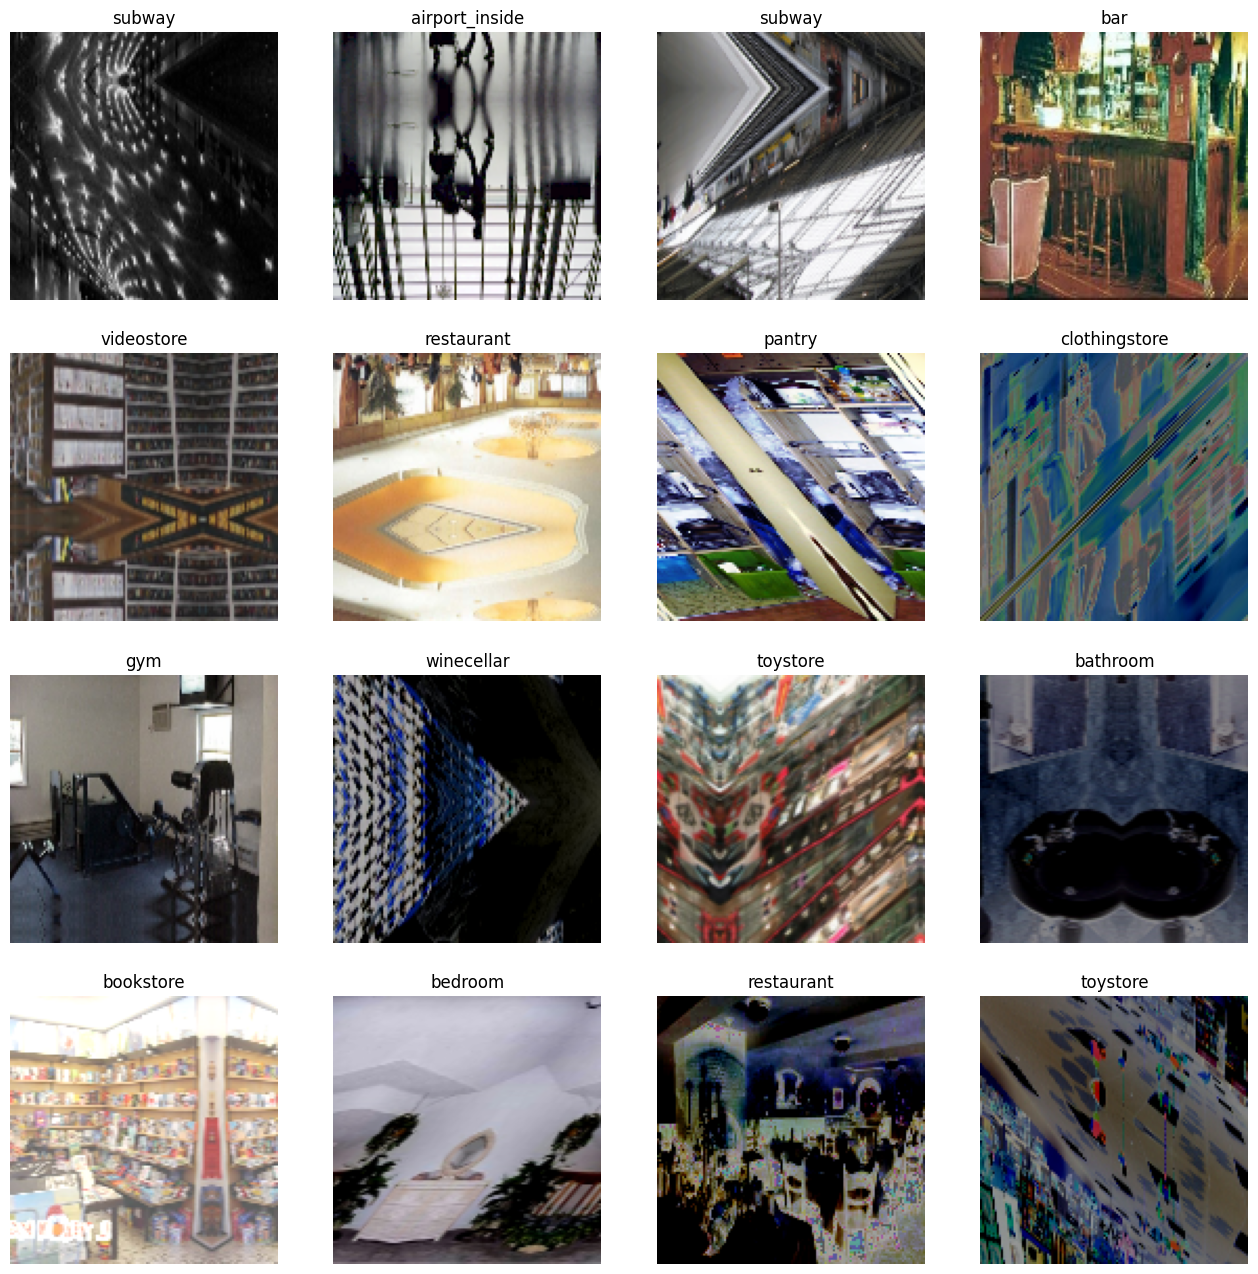

In [ ]:
plt.figure(figsize=(16, 16))

for img, lab in train_data.take(1):

    for i in range(0,16):  # img.shape[0] gives the number of images in the batch
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy())
        # Map the label index to name
        plt.title(IndoorImage_dir[lab[i]])
        plt.axis("off")
    plt.show()

### Print Batch Shapes
This cell prints the shapes of the image and label batches from the training data.

In [ ]:
for image_batch, labels_batch in train_data:
    print(f'image_batch.shape = {image_batch.shape} \nlabels_batch.shape = {labels_batch.shape } ')
    break

image_batch.shape = (32, 128, 128, 3) 
labels_batch.shape = (32,) 


### Analyze Label Distribution
This cell defines a function to get class labels from the datasets and then prints the distribution of labels in both the training and validation sets.

In [ ]:
%%time
# Creating a function to identify the labels.
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

# training_labels = return_class_labels(train_data)
# print("The distribution of training labels is: ", (Counter(training_labels)))

training_labels = return_class_labels(train_data)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(val_data)
print("The distribution of validation labels is: ", (Counter(validation_labels)))



The distribution of training labels is:  Counter({np.int32(37): 547, np.int32(6): 477, np.int32(0): 464, np.int32(4): 450, np.int32(53): 401, np.int32(59): 391, np.int32(10): 386, np.int32(48): 379, np.int32(34): 369, np.int32(3): 300, np.int32(45): 291, np.int32(7): 283, np.int32(19): 258, np.int32(54): 254, np.int32(60): 204, np.int32(22): 203, np.int32(20): 197, np.int32(39): 181, np.int32(31): 178, np.int32(30): 168, np.int32(29): 165, np.int32(8): 161, np.int32(5): 145, np.int32(38): 135, np.int32(2): 135, np.int32(12): 131, np.int32(40): 129, np.int32(56): 127, np.int32(46): 125, np.int32(41): 123, np.int32(35): 118, np.int32(51): 117, np.int32(55): 114, np.int32(58): 113, np.int32(42): 111, np.int32(1): 108, np.int32(15): 107, np.int32(44): 103, np.int32(36): 99, np.int32(21): 98, np.int32(26): 92, np.int32(14): 90, np.int32(49): 87, np.int32(50): 86, np.int32(27): 85, np.int32(11): 85, np.int32(17): 83, np.int32(16): 83, np.int32(32): 82, np.int32(9): 82, np.int32(13): 81, np.i

### Visualize Label Distribution
This cell visualizes the distribution of labels in the training and validation datasets using bar plots.

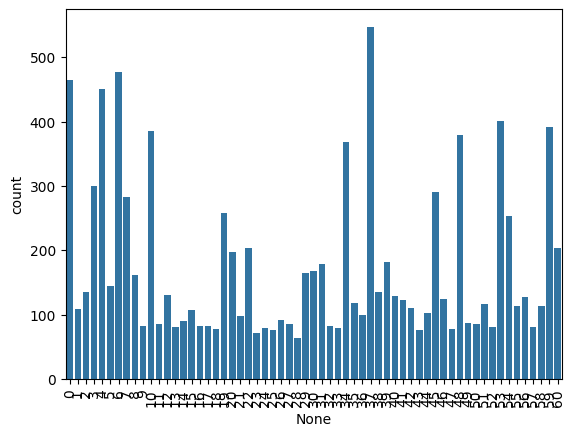

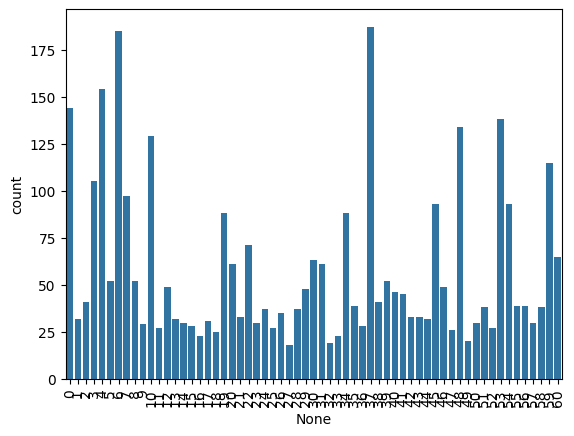

In [ ]:


label_series = pd.Series(return_class_labels(train_data))
sns.countplot(x=label_series)
plt.xticks(rotation=90)
plt.show()

label_series = pd.Series(return_class_labels(val_data))
sns.countplot(x=label_series)
plt.xticks(rotation=90)
plt.show()

### Define Model Checkpoint Callback
This cell defines a ModelCheckpoint callback to save the best model during training based on validation accuracy.

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='best model.keras',
                             save_weights_only=False,save_best_only=True,
                             monitor='val_accuracy')

### Build Custom CNN Model
This cell defines and builds a custom Convolutional Neural Network (CNN) model architecture.

In [ ]:
# This architecture utilizes a convolutional neural network (CNN) where learned features are represented by increasing weighted connections through multiple layers. Each convolutional layer is paired with a normalization layer (Batch Normalization) to scale the extracted features, which helps stabilize and accelerate training.

# Normalized convolutions are propagated through a residual connection structure, utilizing Leaky ReLU activation to provide sparse information to deeper layers and the classification head. The Leaky ReLU function f(n) is employed here to mitigate the "dying ReLU" problem, which can lead to inactive neurons that do not contribute to learning. This allows the network to retain memory for each iterative timestep during the forward and backward passes.


inputs = keras.Input(shape=(imagesize, imagesize, 3))
x = layers.Conv2D(128, (3, 3),padding = 'same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.3)(x)

residual = x #stow activated residual



for axon in [128, 256, 512]:

  x = layers.LeakyReLU(negative_slope=0.3)(x)
  x = layers.SeparableConv2D(axon, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.LeakyReLU(negative_slope=0.3)(x)
  x = layers.SeparableConv2D(axon, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


  residual = layers.Conv2D(axon, 1, strides=2, padding="same")(
      residual)

  x = layers.add([x, residual])  #inject residual
  residual = x                  #left over


  x = layers.add([x, residual])  # Add back residual
  residual= x  # Set aside next residual

x = layers.SeparableConv2D(720, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.3)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(61, activation=None)(x)

model = keras.Model(inputs, outputs)
# model.build(input_shape = input_shape)


### Display Custom Model Summary
This cell displays a summary of the custom CNN model architecture, including layer types, output shapes, and parameter counts.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 128)  │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 128)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 128, 128, 128)  │         17,664 │ leaky_re_lu_1[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 128, 128, 128)  │         17,664 │ leaky_re_lu_2[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         16,512 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 128)    │              0 │ add[0][0], add[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 64, 64, 256)    │         34,176 │ leaky_re_lu_3[0][0]    │
│ (SeparableConv2D)    

 Total params: 1,151,965 (4.39 MB)

 Trainable params: 1,146,685 (4.37 MB)

 Non-trainable params: 5,280 (20.62 KB)

### Build ResNet Model with Keras_CV
This cell builds a ResNet model using `keras_cv.models.ImageClassifier.from_preset` for transfer learning.

In [ ]:
import keras_hub
#Keras preset classifier from Model hub
model2 = keras_hub.models.ImageClassifier.from_preset(
    "resnet_vd_200_imagenet",
    activation="softmax",
    num_classes=61,
    preprocessor=None
)


### Display ResNet Model Summary
This cell displays a summary of the ResNet model architecture.

In [ ]:
model2.summary()

Model: "res_net_image_classifier_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)                    │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone_9 (ResNetBackbone)           │ (None, None, None, 2048)           │          72,884,064 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 61)                         │             124,989 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 73,009,053 (278.51 MB)

 Trainable params: 72,814,493 (277.77 MB)

 Non-trainable params: 194,560 (760.00 KB)

### Build MobileNetV2 Model for Transfer Learning
This cell loads a pre-trained MobileNetV2 model for transfer learning, excluding the top classification layer.

In [ ]:
#making an API call for a transfer learning model, and defining inputshape as is required when building a functional model
basemodel = tf.keras.applications.MobileNetV2(input_shape= ((imagesize,imagesize , 3)),
                                              include_top = False,
                                              weights = 'imagenet')

### Set MobileNetV2 Layers to Trainable
This cell sets the last 10 layers of the MobileNetV2 base model to be trainable for fine-tuning.

In [ ]:
basemodel.trainable = True

for layer in basemodel.layers[-10:]:
    layer.trainable = True

### Display MobileNetV2 Model Summary
This cell displays a summary of the MobileNetV2 base model, showing which layers are trainable.

In [ ]:
basemodel.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Define Prediction Layer
This cell defines a dense layer with softmax activation for the final classification output.

In [ ]:
prediction_layer = tf.keras.layers.Dense(61, activation = 'softmax')



### Build Transfer Learning Model (MobileNetV2)
This cell constructs a new model by adding a classification head on top of the pre-trained MobileNetV2 base model.

### Display Transfer Learning Model Summary
This cell displays a summary of the complete transfer learning model architecture.

In [ ]:


inputs = keras.Input(shape=(imagesize, imagesize, 3))
x = basemodel(inputs,training=False)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(61)(x)
outputs = tf.keras.layers.Activation('softmax')(outputs)
model3 = tf.keras.Model(inputs,outputs)
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 4, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 4, 4, 1024)          │       1,323,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 61)                  │          62,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 61)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,648,893 (13.92 MB)

 Trainable params: 3,612,221 (13.78 MB)

 Non-trainable params: 36,672 (143.25 KB)

### Set Training Parameters and Callbacks
This cell sets training parameters like initial learning rate and defines callbacks for learning rate reduction and TensorBoard logging.

In [ ]:
STEPS=10542//batchsize
first_decay_steps = STEPS * 5 #5,10,20,40

import datetime
initial_epoch = 0

initial_learning_rate=1e-5

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6,verbose=1)

from tensorflow.keras.callbacks import TensorBoard
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Compile Models
This cell compiles the custom CNN and transfer learning models with specified optimizers, loss functions, and metrics.

In [ ]:
compile1 = model.compile(tf.keras.optimizers.Adam(learning_rate = initial_learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(from_logits= True), metrics=["accuracy"])

# compile2 = model2.compile(tf.keras.optimizers.Adam(learning_rate = initial_learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics=["accuracy"])

compile3 = model3.compile(tf.keras.optimizers.Adam(learning_rate = initial_learning_rate), loss=keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics=["accuracy"])

### Train Models and Save Checkpoints
This cell trains the custom CNN and transfer learning models, saving the best models based on validation accuracy.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
path = '/content/'
files = ['best_model_1_save_at_{epoch}.keras','best_model_2_save_at_{epoch}.keras','best_model_3_save_at_{epoch}.keras']
# Create ModelCheckpoint callbacks for each model
checkpoint1 = ModelCheckpoint(path + files[0], monitor='val_accuracy', save_best_only=True, mode='max')
# checkpoint2 = ModelCheckpoint(filepath=path + files[1], monitor='val_accuracy', save_best_only=True, mode='max')
checkpoint3 = ModelCheckpoint(filepath= path + files[2], monitor='val_accuracy', save_best_only=True, mode='max')

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# if os.path.exists(path+'_'+files[0]):
tf.keras.models.load_model('/content/best_model_1_save_at_{epoch}.keras')
# not os.path.exists(path+files[0]):

compile1

history = model.fit(train_data, epochs=60, batch_size=batchsize, verbose=1, validation_data=val_data, steps_per_epoch=STEPS,callbacks=[lr_schedule ,checkpoint1, tensorboard_callback])
model.save(path+files[0])
print(f"Model saved to {path + 'latest_'+files[0]}")
# else:
  # tf.keras.models.load_model('/content/_best_model_1_save_at_{epoch}(3).keras')

  # history = model.fit(train_data, epochs=60, batch_size=batchsize, verbose=1, validation_data=val_data, steps_per_epoch=STEPS,callbacks=[lr_schedule ,checkpoint1, tensorboard_callback])
  # model.save(path + '_'+files[0])

# if not os.path.exists(path+files[1]):

#   compile2

#   history = model2.fit(train_data, epochs=50,  verbose=1, validation_data=val_data, steps_per_epoch=STEPS,callbacks=[lr_schedule ,checkpoint2, tensorboard_callback])
#   model.save(path+'_'+files[1])
#   print(f"Model saved to {path + '_'+files[1]}")
# else:
#   tf.keras.models.load_model(path+files[1])

#   history2 = model2.fit(train_data, epochs=10, batch_size=batchsize, verbose=1, validation_data=val_data, steps_per_epoch=STEPS,callbacks=[lr_schedule ,checkpoint2, tensorboard_callback])
#   model.save(path+'_'+files[1])
#   print(f"Model saved to{path+'_'+files[1]}")

# if not os.path.exists(path+files[2]):
tf.keras.models.load_model('/content/best_model_3_save_at_30.keras')
compile3

history3 = model3.fit(train_data, epochs=60,initial_epoch=initial_epoch, batch_size=batchsize, verbose=1, validation_data=val_data,steps_per_epoch=STEPS, callbacks=[lr_schedule, checkpoint3,tensorboard_callback])
model.save(path+'_'+files[2])
print(f"Model saved to{path+'latest_'+files[2]}")
# else:
  # tf.keras.models.load_model(path+files[2])

  # history3 = model.fit(train_data, epochs=60, batch_size=batchsize, verbose=1, validation_data=val_data, steps_per_epoch=STEPS,callbacks=[lr_schedule ,checkpoint3,tensorboard_callback])
  # model.save(path+'_'+files[2])
  # print(f"Model saved to{path+'_'+files[2]}")

Epoch 1/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 155ms/step - accuracy: 0.1109 - loss: 3.6300 - val_accuracy: 0.1733 - val_loss: 3.3433 - learning_rate: 1.0000e-05
Epoch 2/60
  1/329 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.1250 - loss: 3.4857

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1250 - loss: 3.4857 - val_accuracy: 0.1736 - val_loss: 3.3430 - learning_rate: 1.0000e-05
Epoch 3/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 155ms/step - accuracy: 0.1098 - loss: 3.6165 - val_accuracy: 0.1821 - val_loss: 3.3132 - learning_rate: 1.0000e-05
Epoch 4/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1250 - loss: 3.4206 - val_accuracy: 0.1821 - val_loss: 3.3131 - learning_rate: 1.0000e-05
Epoch 5/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.1023 - loss: 3.6224 - val_accuracy: 0.1818 - val_loss: 3.3311 - learning_rate: 1.0000e-05
Epoch 6/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1250 - loss: 3.6570 - val_accuracy: 0.1818 - val_loss: 3.3325 - learning_rate: 1.0000e-05
Epoch 7/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.1083 - loss: 3.5838 - val_accuracy: 0.1705 - val_loss: 3.3047 - learning_rate: 1.0000e-05
Epoch 8/60
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy

### Plot Model Accuracy
This cell defines a function to plot the training and validation accuracy curves and then plots them for the trained models.

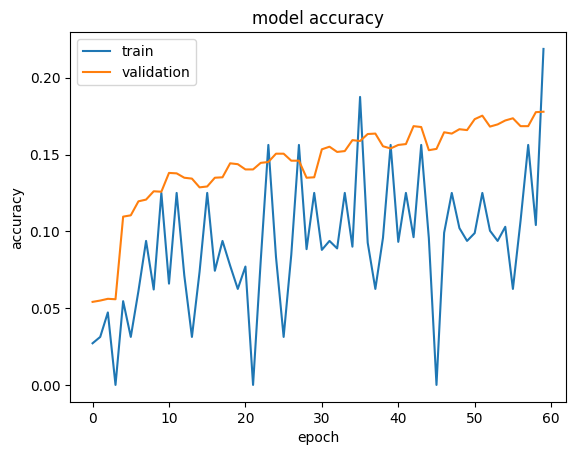

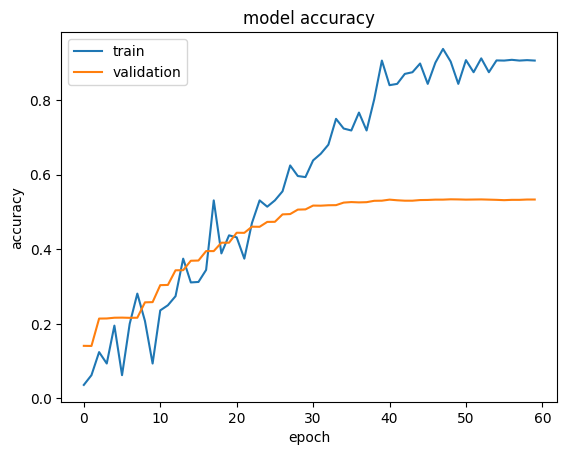

In [ ]:


import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)
# plot_hist(history2)
plot_hist(history3)



### Plot Model Loss
This cell defines a function to plot the training and validation loss curves and then plots them for the trained models.

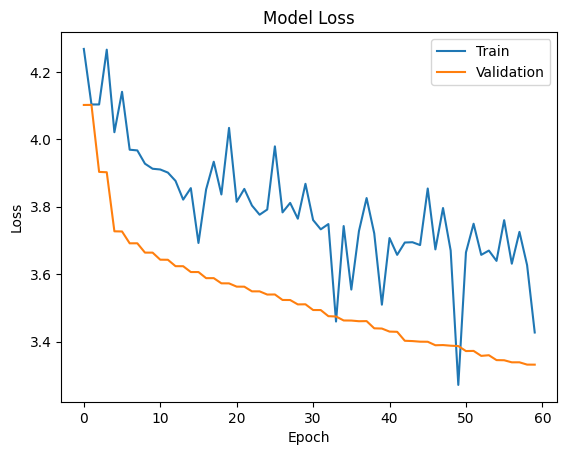

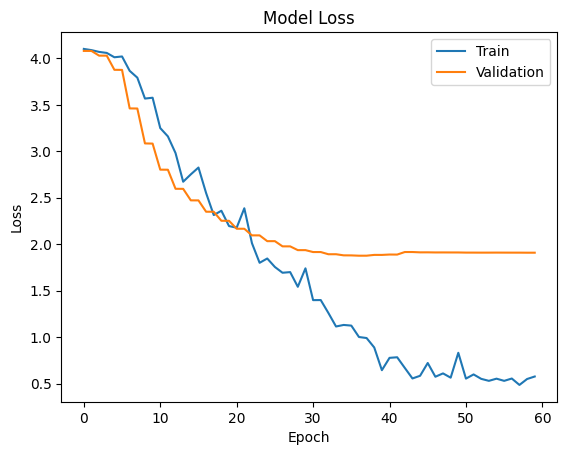

In [ ]:
def plot_loss_curves(hist):

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.show()

plot_loss_curves(history)
# plot_loss_curves(history2)
plot_loss_curves(history3)

### Visualize Predictions from Transfer Learning Model (MobileNetV2)
This cell visualizes a batch of images from the validation data and displays the predictions and probabilities from the transfer learning model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


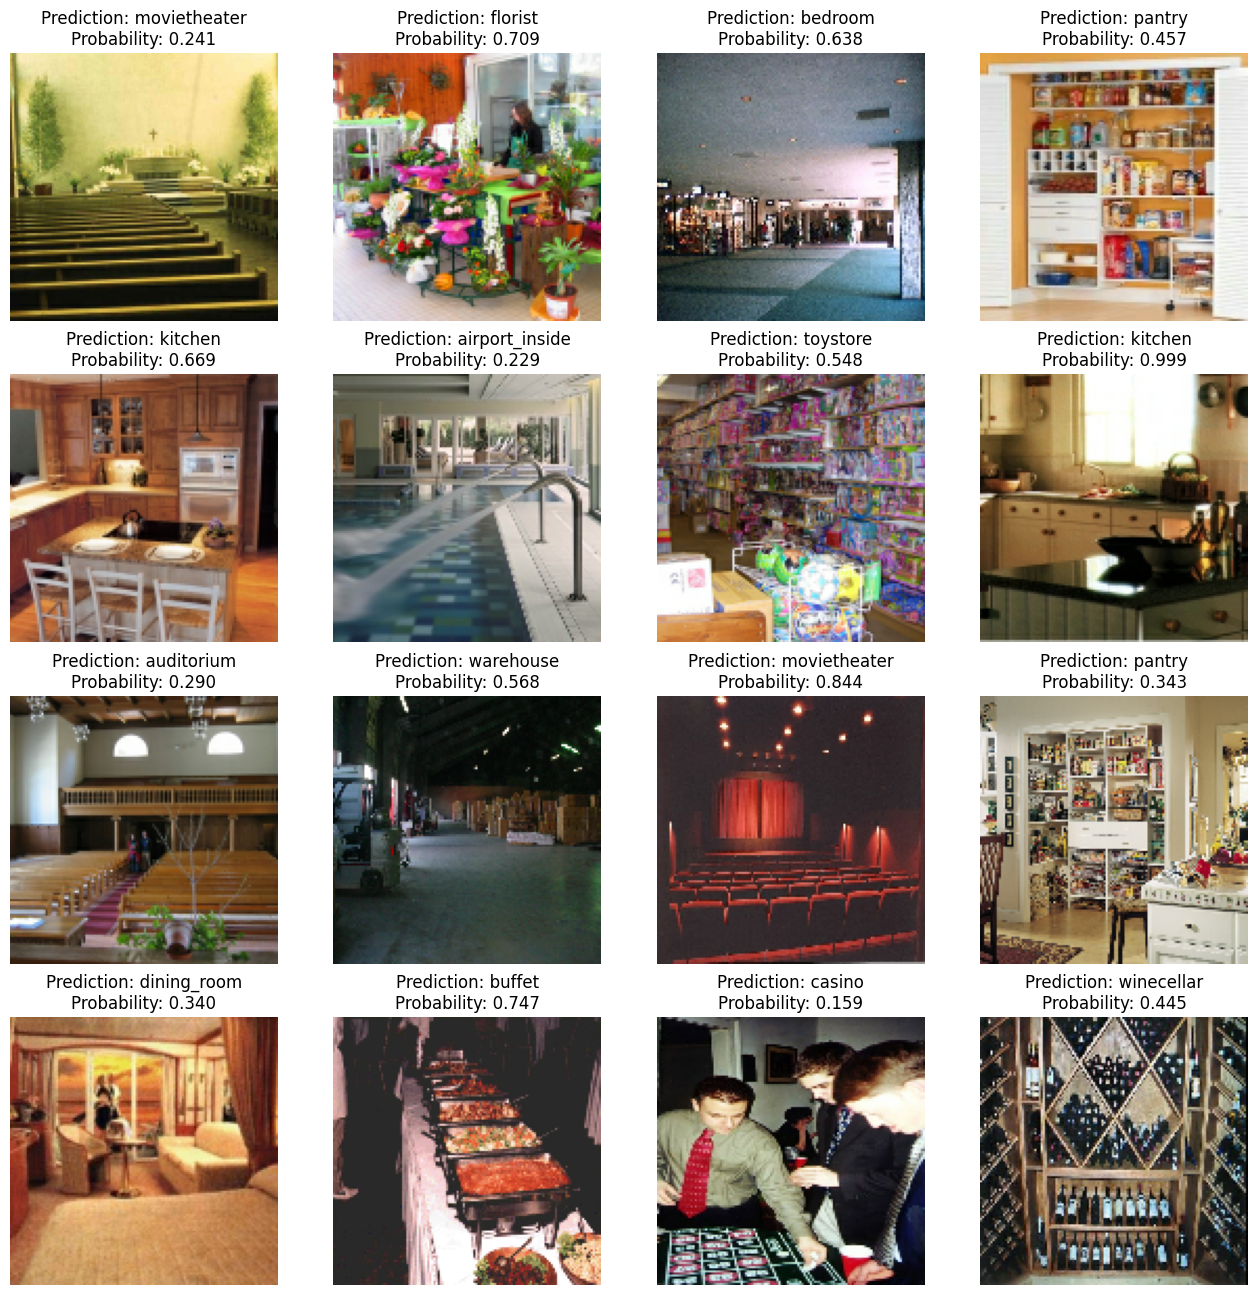

In [ ]:
skip_batches = 3



plt.figure(figsize=(16, 16))
a=[0,1,2]
for img, lab in val_data.skip(skip_batches).take(1):
  probabilities = model3.predict(img)
  predicted_class_indices = np.argmax(probabilities, axis=1)

  for i in range(0,16):  # img.shape[0] gives the number of images in the batch
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(img[i].numpy())
      # Map the label index to name
      predicted_class_name = IndoorImage_dir[predicted_class_indices[i]]

      title = f"Prediction: {predicted_class_name}\nProbability: {probabilities[i][predicted_class_indices[i]]:.3f}"
      plt.title(title)
      plt.axis("off")
  plt.show()

### Evaluate Models
This cell defines a function to evaluate the models on the validation data and prints the classification report.

In [ ]:
def evaluate_model(model, val_data):

    if model == model2 or model3:
      val_predictions = model.predict(val_data)
    else:
      logits = model.predict(img[0][0:32])
      softmaxprobs =keras.ops.softmax(logits)
      print(softmaxprobs)

    val_pred_classes = np.argmax(val_predictions, axis=1)


    val_true_classes = []
    for images, labels in val_data:
        val_true_classes.extend(labels.numpy())


    report = classification_report(val_true_classes, val_pred_classes)


    print(report)


evaluate_model(model, val_data)
# evaluate_model(model2, val_data)
evaluate_model(model3, val_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
              precision    recall  f1-score   support

           0       0.18      0.46      0.26       144
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        41
           3       0.25      0.16      0.20       105
           4       0.16      0.52      0.25       154
           5       0.00      0.00      0.00        52
           6       0.20      0.16      0.18       185
           7       0.19      0.10      0.13        97
           8       0.50      0.04      0.07        52
           9       0.00      0.00      0.00        29
          10       0.33      0.30      0.32       129
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        49
          13       0.00      0.00      0.00        32
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00        28
          16       0.00      0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       144
           1       0.18      0.12      0.15        32
           2       0.38      0.49      0.43        41
           3       0.56      0.62      0.59       105
           4       0.53      0.41      0.46       154
           5       0.63      0.62      0.62        52
           6       0.74      0.76      0.75       185
           7       0.56      0.70      0.62        97
           8       0.50      0.75      0.60        52
           9       0.39      0.55      0.46        29
          10       0.73      0.76      0.75       129
          11       0.33      0.30      0.31        27
          12       0.66      0.82      0.73        49
          13       0.48      0.47      0.48        32
          14       0.62      0.83      0.71        30
          15       0.53      0.75      0.62        28
          16       0.40      0.09      